# Import data

In [2]:
import json

with open('companies_cross.json', 'r') as f:
    companies = json.load(f)

In [3]:
from collections import Counter

# Let's use only companies that we currently have website of (at least some pages)
companies = [c for c in companies if c.get('path_to')]

# Let's also limit the number of sites (because this is not cleaned yet)
companies = [c for c in companies if c.get('current_site_count', 0) < 100]

# Let's use only well represented industries
industries = Counter([c['industry'] for c in companies])
companies = [c for c in companies if industries[c.get('industry')] > 500]

### Some helper methods

In [4]:
import os

import logging

# set root logger level
root_logger = logging.getLogger()
root_logger.setLevel(logging.DEBUG)

# setup custom logger
logger = logging.getLogger(__name__)
handler = logging.FileHandler('extract_features.log')
handler.setLevel(logging.INFO)
logger.addHandler(handler)


def get_texts_for_domain(path, file_name):
    text_file = os.path.join(path, file_name)
    if not os.path.exists(text_file):
        text = None
        text_file = '/dev/null'
    else:
        with open(text_file, 'r') as f:
            text = f.read()
    return text, text_file


def get_full_text(path):
    return get_texts_for_domain(path, 'full_texts.txt')


def get_nav_text(path):
    return get_texts_for_domain(path, 'nav_menu.txt')


def get_meta_descriptions_text(path):
    return get_texts_for_domain(path, 'descriptions.txt')


def get_meta_keywords_text(path):
    return get_texts_for_domain(path, 'keywords.txt')


def get_titles_text(path):
    return get_texts_for_domain(path, 'titles.txt')

# Classify

## Prepare pipeline

In [5]:
# Create transformers
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm

def extract_from_company(companies, func):
    paths = []
    for company in tqdm(companies):
        text, path = func(company['path_to'])
        paths.append(path)
    return paths

def get_full_text_from_company(companies):
    return extract_from_company(companies, get_full_text)

def get_nav_menus_from_company(companies):
    return extract_from_company(companies, get_nav_text)

def get_descriptions_from_company(companies):
    return extract_from_company(companies, get_meta_descriptions_text)

def get_titles_from_company(companies):
    return extract_from_company(companies, get_titles_text)

def get_keywords_from_company(companies):
    return extract_from_company(companies, get_meta_keywords_text)


full_text_transformer = FunctionTransformer(get_full_text_from_company, validate=False)
nav_menus_transformer = FunctionTransformer(get_nav_menus_from_company, validate=False)
descriptions_transformer = FunctionTransformer(get_descriptions_from_company, validate=False)
titles_transformer = FunctionTransformer(get_titles_from_company, validate=False)
keywords_transformer = FunctionTransformer(get_keywords_from_company, validate=False)

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline, FeatureUnion
from numpy import concatenate

hv = HashingVectorizer(non_negative=True, input='filename')
tfv = TfidfVectorizer(input='filename', max_features=3000)
tf_transformer = TfidfTransformer()
clf = SGDClassifier(loss='hinge', penalty='l2', n_iter=10, alpha=0.001, n_jobs=10)#, class_weight='balanced')
clf2 = SGDClassifier(loss='hinge', n_iter=10, alpha=0.001, n_jobs=10)#, class_weight='balanced')
lda = LatentDirichletAllocation(n_topics=100, learning_method='batch', max_iter=5, n_jobs=5, learning_offset=50.)

pipeline_elements = [('HV', hv), ('tfid', tf_transformer), ('svc', clf)]
pipe = Pipeline(pipeline_elements)

In [489]:
# training = companies[:80000]
# counter_train = Counter([c['industry'] for c in training])
# min_freq = counter_train.most_common()[-1][1]
# lda_train = []
# c_lda = Counter()
# for company in tqdm(training):
#     if c_lda.get(company['industry'], 0) < 50:
#         text, file_name = get_full_text(company['path_to'])
#         if text:
#             lda_train.append(company)
#             c_lda = Counter([c['industry'] for c in lda_train])


only_lda = Pipeline([('Full', full_text_transformer), ('CV', cv), ('tfid', tf_transformer), ('lda', lda)])
# only_lda.fit(lda_train)

def lda_add(data):
    lda_output = lda.transform(data)
    return hstack((data, lda_output))
    return lda_output


lda_transformer = FunctionTransformer(lda_add, validate=False)



In [18]:
from sklearn.ensemble import VotingClassifier

pipe_full = Pipeline([('Full', full_text_transformer)] + pipeline_elements)
pipe_nav_menus = Pipeline([('Navs', nav_menus_transformer)] + pipeline_elements)
pipe_descriptions = Pipeline([('Descriptions', descriptions_transformer)] + pipeline_elements)
pipe_titles = Pipeline([('Titles', titles_transformer)] + pipeline_elements)
pipe_keywords = Pipeline([('Keywords', keywords_transformer)] + pipeline_elements)

identity = FunctionTransformer(None, validate=False)
lda_union = FeatureUnion([('lda', lda), ('identity', identity)])
pipe_lda = Pipeline([('Full', full_text_transformer),
                     ('tfv', tfv),
                     ('lda_union', lda_union),
#                      ('lda', lda),
                     ('clf', clf2)
                    ])

voting = VotingClassifier(estimators=[('full', pipe_full),
                                      ('navs', pipe_nav_menus),
                                      ('desc', pipe_descriptions),
                                      ('titles', pipe_titles),
                                      ('keywords', pipe_keywords)
#                                       ('lda', pipe_lda)
                                     ],
                         voting='hard')  # TODO Try with adding keywords

## Fit and test

In [358]:
companies_orig = companies

companies = [c for c in companies if c['website_lang'] == 'en']

# 171266 vs 110254

In [8]:
from sklearn.utils import shuffle
from scipy.sparse import hstack


companies = shuffle(companies)

target = []
train_data = []

for company in tqdm(companies):
    text, file_name = get_full_text(company['path_to'])
    if text:
        train_data.append(company)
        industry = company['industry']
#         industry = industry if industry == 'Food & Beverages' else 'Not'
        target.append(industry)
#         target.append(company['company_size_clean'])

# new = extract_matrix(train_data)

# Fit
# clf2.fit(new, target)

# pipe_lda_final.fit(train_data, target)
# voting.fit(train_data, target)
# pipe_full.fit(train_data, target)

100%|██████████| 171266/171266 [02:23<00:00, 1196.53it/s]


In [ ]:
# Select the best in voting
from sklearn.grid_search import GridSearchCV

params = [{'voting': ['hard', 'soft']},
          {'voting': ['hard'],
          'weights': [[1, 1, 1, 1], [2, 1.5, 1.2, 1.2], [1, 1.2, 1.2, 1], [1.5, 1, 1, 1]]}]
params = params[1]

grid = GridSearchCV(voting, param_grid=params, scoring=score_similar)
grid.fit(train_data, target)

TODO:
- testiraj uspesnost nav, descriptions, etc. ko gledamo samo strani, ki to imajo in primerjaj to z dejansko uspesnostjo
- testiraj pipe_full na stevilu zaposlenih
- testiraj lda na popravljenih podatkih

In [ ]:
from sklearn.cross_validation import cross_val_score

score_nav = cross_val_score(pipe_nav_menus, train_data, target, scoring=score_similar, n_jobs=5)
print("***** score_nav *****")
print(score_nav.mean())
score_titles = cross_val_score(pipe_titles, train_data, target, scoring=score_similar, n_jobs=5)
print("***** score_titles *****")
print(score_titles.mean())
score_descriptions = cross_val_score(pipe_descriptions, train_data, target, scoring=score_similar, n_jobs=5)
print("***** score_descriptions *****")
print(score_descriptions.mean())
score_keywords = cross_val_score(pipe_keywords, train_data, target, scoring=score_similar, n_jobs=5)
print("***** score_keywords *****")
print(score_keywords.mean())

params = {
    'voting': ['hard'],
    'weights': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 0], [1.7, 1, 1, 1, 1], [1, 1, 0.5, 0.5, 0.5], [1, 0.5, 1, 1, 0.5]]
}

grid = GridSearchCV(voting, param_grid=params, scoring=score_similar)
grid.fit(train_data, target)

100%|██████████| 106772/106772 [00:20<00:00, 5192.19it/s]

100%|██████████| 53416/53416 [00:02<00:00, 26400.35it/s]


***** score_nav *****
0.27467142131


100%|██████████| 106740/106740 [00:27<00:00, 3905.03it/s]

100%|██████████| 53416/53416 [00:11<00:00, 4454.56it/s]


***** score_titles *****
0.401709146636


100%|██████████| 106740/106740 [00:20<00:00, 5172.66it/s]

100%|██████████| 53416/53416 [00:02<00:00, 26121.68it/s]


***** score_descriptions *****
0.313623645956


100%|██████████| 106772/106772 [00:06<00:00, 15801.33it/s]

100%|██████████| 53384/53384 [00:01<00:00, 27554.83it/s]


***** score_keywords *****
0.219807591855


 80%|████████  | 85636/106740 [00:15<00:00, 25897.79it/s]

In [16]:
# Select the best
from sklearn.grid_search import GridSearchCV

params = {
#     'svc__penalty': ['l1', 'l2'],
#     'svc__alpha': [0.001, 0.01, 0.1],
#     'svc__n_iter': [5, 10, 100],
#     'svc__class_weight': [None, 'balanced']
#     'HV__stop_words': [None, 'english']
    'svc__loss': ['log'],
    'svc__epsilon': [0.1, 5]
         }

grid = GridSearchCV(pipe_full, param_grid=params, scoring=score_similar, n_jobs=3)
grid.fit(train_data, target)

100%|██████████| 160156/160156 [00:14<00:00, 11417.61it/s]


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('Full', FunctionTransformer(accept_sparse=False,
          func=<function get_full_text_from_company at 0x7f814e0cdd08>,
          pass_y=False, validate=False)), ('HV', HashingVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'svc__loss': ['log'], 'svc__epsilon': [0.1, 5]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function score_similar at 0x7f814814ae18>, verbose=0)

In [17]:
grid.grid_scores_

[mean: 0.16104, std: 0.00171, params: {'svc__loss': 'log', 'svc__epsilon': 0.1},
 mean: 0.16124, std: 0.00073, params: {'svc__loss': 'log', 'svc__epsilon': 5}]

In [ ]:
# Try getting something valuable out of LDA

lda_params = [
    {'tfv__max_features': [1000, 2000, 4000]},
#     {'lda_union__lda__n_topics': [10, 50, 90]}
    {'lda__n_topics': [10, 50, 90],
]

grid_lda = GridSearchCV(pipe_lda, param_grid=lda_params, scoring=score_similar)#, n_jobs=3)

grid_lda.fit(train_data[:70000], target[:70000])

 42%|████▏     | 9881/23335 [00:00<00:00, 24602.02it/s]

In [578]:
grid_lda.grid_scores_

[mean: 0.32098, std: 0.00189, params: {'tfv__max_features': 3000},
 mean: 0.36871, std: 0.00153, params: {'tfv__max_features': 10000}]

In [ ]:
grid_lda

In [ ]:
lda_params ={
    'tfv__max_features': [3000, 10000],
#     'lda_union__lda__learning_offset': [10., 50.],
#     'clf__alpha': [0.01, 0.001]
}

grid_lda = GridSearchCV(pipe_lda, param_grid=lda_params, scoring=score_similar)#, n_jobs=3)

grid_lda.fit(train_data, target)

100%|██████████| 106772/106772 [00:09<00:00, 11075.45it/s]


### Balance the data

In [64]:
len(train_dataset)

40500

In [60]:
from collections import Counter

industries = Counter([c['industry'] for c in companies])
industries.most_common()

train_dataset = []
counter = Counter()

for company in tqdm(companies):
    if counter.get(company['industry'], 0) < 450:
        train_dataset.append(company)
        counter = Counter([c['industry'] for c in train_dataset])



100%|██████████| 171266/171266 [06:13<00:00, 458.87it/s]  


In [263]:
pipe_lda_final.steps

[('lda', Pipeline(steps=[('Full', FunctionTransformer(accept_sparse=False,
            func=<function get_full_text_from_company at 0x7f08b270c8c8>,
            pass_y=False, validate=False)), ('CV', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8...ol=0.1, random_state=None,
               topic_word_prior=None, total_samples=1000000.0, verbose=0))])),
 ('svc',
  SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
         eta0=0.0, fit_intercept=True, l1_ratio=0.15,
         learning_rate='optimal', loss='hinge', n_iter=100, n_jobs=10,
         penalty='l2', power_t=0.5, random_state=None, shuffle=True,
         verbose=0, warm_start=False))]

In [561]:
test_data = []

for company in tqdm(companies[-10000:]):
    text, file_name = get_full_text(company['path_to'])
    if text:
        test_data.append(company)

score_voting = voting.score(test_data, [c['industry'] for c in test_data])  # 39% -> 40% eng  44% adjusted
# score_full = pipe_full.score(test_data, [c['company_size_clean'] for c in test_data])  # 52.3% -> 53.8% eng
# nav_menus - 21%
# descriptions - 28%
# cutoff industries 500 - 750 - 2%
# added lda (4000, 90) - 26%

100%|██████████| 8435/8435 [00:00<00:00, 25251.53it/s]


In [562]:
score_voting

0.3805572021339656

In [408]:
sizes = {
    '1': 1,
    '1-10': 2,
    '11-50': 3,
    '51-200': 4,
    '201-500': 5,
    '501-1000': 6,
    '1001-5000': 7,
    '5001-10,000': 8,
    '10,001+': 9,
}

actual = [c['company_size_clean'] for c in test_data]
predicted = pipe_full.predict(test_data)
correct = 0
for p, a in zip(predicted, actual):
    if abs(sizes.get(p) - sizes.get(a)) < 2:
        correct += 1

correct / len(actual)

100%|██████████| 6744/6744 [00:00<00:00, 23413.21it/s]


0.741399762752076

In [584]:
score_similar(voting, test_data, [c['industry'] for c in test_data])

AttributeError: 'VotingClassifier' object has no attribute 'estimators_'

In [609]:
from sklearn.dummy import DummyClassifier

# Always most frequent - 8.3%
# Based on freq - 4.2%
# Random 2.4%

dummy = DummyClassifier(strategy='stratified', constant='Marketing and Advertising')
dummy.fit(train_data, target)

DummyClassifier(constant='Marketing and Advertising', random_state=None,
        strategy='stratified')

In [610]:
score_similar(dummy, [[1, 1, 1] for t in test_data], [c['industry'] for c in test_data])

0.04184943687018373

## Evaluate

In [484]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score

expected = [c['industry'] for c in test_data]
predicted = voting.predict(test_data)
# predicted = ['Not' if p > 0 else 'Food & Beverages' for p in predicted_prob]

print("Classification report for classifier:\n%s\n"
      % classification_report(expected, predicted))
print("Confusion matrix:\n%s" % confusion_matrix(expected, predicted))

100%|██████████| 6719/6719 [00:00<00:00, 26926.25it/s]


Classification report for classifier:
             precision    recall  f1-score   support

 Accounting       0.29      0.53      0.37        34
Airlines/Aviation       0.39      0.31      0.35        29
Apparel & Fashion       0.36      0.46      0.40        69
Architecture & Planning       0.09      0.74      0.16        91
 Automotive       0.39      0.60      0.47        96
Aviation & Aerospace       0.24      0.15      0.18        27
    Banking       0.54      0.66      0.59        50
Biotechnology       0.35      0.36      0.36        36
Broadcast Media       0.35      0.25      0.29        52
Building Materials       0.23      0.13      0.17        53
Business Supplies and Equipment       0.25      0.05      0.09        37
  Chemicals       0.36      0.36      0.36        28
Civic & Social Organization       0.20      0.15      0.17        54
Civil Engineering       0.00      0.00      0.00        27
Computer Games       0.44      0.44      0.44        27
Computer Software     

Confusion matrix, without normalization
[[22  0  0 ...,  0  0  0]
 [ 0  5  0 ...,  0  0  0]
 [ 1  0 35 ...,  0  0  0]
 ..., 
 [ 1  0  0 ...,  7  0  0]
 [ 0  0  3 ...,  0  2  0]
 [ 0  0  0 ...,  0  0 13]]


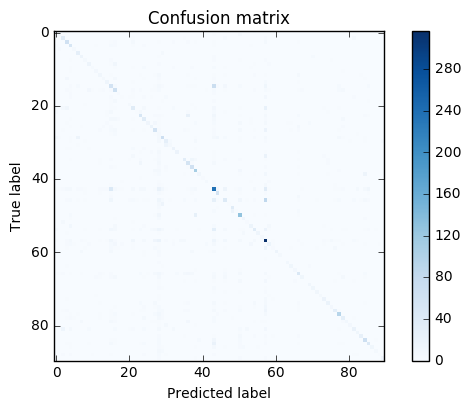

In [96]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
plt.figure()
plot_confusion_matrix(confusion_matrix(expected, predicted), classes=voting.classes_)
plt.show()

In [14]:
with open('similar_industries.json', 'r') as f:
    similar_industries = json.load(f)

In [15]:

def score_similar(estimator, data, actual):
    predict = estimator.predict(data)
#     actual = [c['industry'] for c in actual]
    expected_count = Counter(actual)
    results = {}
    for num, example in enumerate(actual):
        if example == predict[num]:
            results[example] = results.get(example, 0) + 1
        elif predict[num] in similar_industries.get(example, []):
            results[example] = results.get(example, 0) + 0.5

    for key, value in results.items():
        results[key] = value / expected_count[key]

#     print(recall_score(expected, predicted, average='weighted'))
    return sum([v * expected_count[key] / len(actual) for key, v in results.items()])

### Check accuracy for specific industries

In [184]:
from collections import Counter, defaultdict

test_industries = Counter([c['industry'] for c in test_data])
company_accuracy = defaultdict(int)

for company, predict in zip(test_data, predicted):
    if company['industry'] == predict:
        company_accuracy[company['industry']] += 1

for key, item in company_accuracy.items():
    company_accuracy[key] = round(item / test_industries[key] * 100, 2)

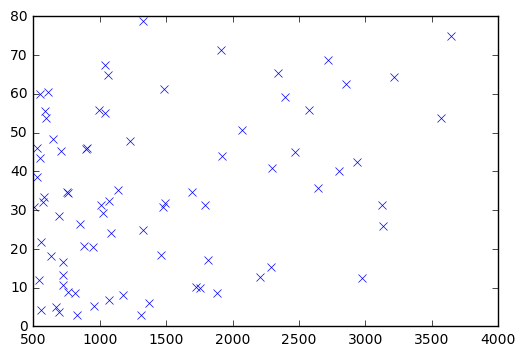

In [194]:
y = []
x = []
for key, item in company_accuracy.items():
    if industries[key] < 4000:
        y.append(item)
        x.append(industries[key])
    
plt.plot(x, y, 'x')